# Creating datasets for GNN analysis

In [1]:
#####################################################
# Basic codes to generate datasets for GNN analysis #
# Created by : Au Jit Seah                          #
# File owners : Au Jit Seah                         #
#####################################################
import os
import pandas as pd
import numpy as np
import csv
import seaborn as sns

import networkx as nx
import codecs
import io
import math

# matplotlib graphs will be included in notebook
%matplotlib inline
import matplotlib.pyplot as plt

PROJECT_ROOT_DIR = "."
FOLDER = "datasets"

ba_edgelist_csv = "ba_graph.csv"

In [2]:
"""synthetic_structsim.py
    Utilities for generating certain graph shapes.
"""

def ba(start, width, role_start=0, m=5):
    """Builds a BA preferential attachment graph, with index of nodes starting at start
    and role_ids at role_start
    INPUT:
    -------------
    start       :    starting index for the shape
    width       :    int size of the graph
    role_start  :    starting index for the roles
    OUTPUT:
    -------------
    graph       :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    """
    graph = nx.barabasi_albert_graph(width, m)
    graph.add_nodes_from(range(start, start + width))
    nids = sorted(graph)
    mapping = {nid: start + i for i, nid in enumerate(nids)}
    graph = nx.relabel_nodes(graph, mapping)
    roles = [role_start for i in range(width)]
    return graph, roles

def house(start, role_start=0):
    """Builds a house-like graph, with index of nodes starting at start
    and role_ids at role_start
    INPUT:
    -------------
    start       :    starting index for the shape
    role_start  :    starting index for the roles
    OUTPUT:
    -------------
    graph       :    a house shape graph, with ids beginning at start
    roles       :    list of the roles of the nodes (indexed starting at
                     role_start)
    """
    graph = nx.Graph()
    graph.add_nodes_from(range(start, start + 5))
    graph.add_edges_from(
        [
            (start, start + 1),
            (start + 1, start + 2),
            (start + 2, start + 3),
            (start + 3, start),
        ]
    )
    # graph.add_edges_from([(start, start + 2), (start + 1, start + 3)])
    graph.add_edges_from([(start + 4, start), (start + 4, start + 1)])
    roles = [role_start, role_start, role_start + 1, role_start + 1, role_start + 2]
    return graph, roles

In [3]:
# build_graph(20, "ba", [["house"]], start=0, m=5)
def build_graph(width_basis, basis_type, list_shapes, start=0,
                rdm_basis_plugins=False,add_random_edges=0, m=5):
    """This function creates a basis (scale-free, path, or cycle)
    and attaches elements of the type in the list randomly along the basis.
    Possibility to add random edges afterwards.
    INPUT:
    --------------------------------------------------------------------------------------
    width_basis      :      width (in terms of number of nodes) of the basis
    basis_type       :      (torus, string, or cycle)
    shapes           :      list of shape list (1st arg: type of shape,
                            next args:args for building the shape,
                            except for the start)
    start            :      initial nb for the first node
    rdm_basis_plugins:      boolean. Should the shapes be randomly placed
                            along the basis (True) or regularly (False)?
    add_random_edges :      nb of edges to randomly add on the structure
    m                :      number of edges to attach to existing node (for BA graph)
    OUTPUT:
    --------------------------------------------------------------------------------------
    basis            :      a nx graph with the particular shape
    role_id          :      labels for each role
    plugins          :      node ids with the attached shapes
    """
    
    print("------ Building the Synthetic BA graph with 'House' motifs ------")
    # Build the BA graph start with 0 and number of nodes (width basis)
    if basis_type == "ba":
        # Drawing of a house motif
        basis, role_id = eval(basis_type)(start, width_basis, m=m)
        print("Role Id of the BA graph :\n", role_id)
#     else:
#         # Drawing other type of motif
#         basis, role_id = eval(basis_type)(start, width_basis)

    n_basis, n_shapes = nx.number_of_nodes(basis), len(list_shapes)
    start += n_basis  # indicator of the id of the next node
    print("Indicator of the id of the next node :", start)
    
    # role_id are '0's for all the nodes of the basis, BA graph
    print("Number of nodes in the BA graph : ", n_basis)
    print("Number of motifs : ", n_shapes)

    print("List of shapes :", list_shapes)
    print("No. of shapes :", len(list_shapes))

    # Sample (with replacement) where to attach the new motifs
    if rdm_basis_plugins is True:
        plugins = np.random.choice(n_basis, n_shapes, replace=False)
    else:
        spacing = math.floor(n_basis / n_shapes)
        print("Spacing : ", spacing)
        plugins = [int(k * spacing) for k in range(n_shapes)]
        print("Plugins : ", plugins)
    seen_shapes = {"basis": [0, n_basis]}
    print("seen_shapes : ", seen_shapes)
    
    for shape_index, shape in enumerate(list_shapes):
        shape_type = shape[0]
        print("\n-----------------------------------------")
        print("Shape_ID : " + str(shape_index) + " with shape type : " + str(shape_type))
        print(str(len(shape)) + " shapes with list of Shape :", shape)
        print("The shape starts from index 1 : ", shape[1:])
        
        args = [start]
        
        # More than one shape
        if len(shape) > 1:
            args += shape[1:]
        
        # Append 0 for the "role_start" in "house" function
        args += [0]
        print("\nThe list of arguments :", args)
        # *args parameter to send a non-keyworded variable-length argument list to function, 1-2 parameters in this case
        print("The first item in list of arguments :", args[0])
        print("The second item in list of arguments :", args[1])
        
        # Creating the "house" motif
        graph_s, roles_graph_s = eval(shape_type)(*args)
        n_s = nx.number_of_nodes(graph_s)
        
        try:
             # Get the last seen label from first index
            col_start = seen_shapes[shape_type][0]
        except:
            # Get the max label value 1
            col_start = np.max(role_id) + 1
            # Add the new shape_type to the seen_shapes dictionary
            seen_shapes[shape_type] = [col_start, n_s]
        print("Column start :", col_start)
        print("Observe seen_shapes : ", seen_shapes)
        
        
        # Attach the shape to the basis, BA graph
        basis.add_nodes_from(graph_s.nodes())
        basis.add_edges_from(graph_s.edges())
        # Connecting the motif to the BA graph from node 20 to 0, 25 to 6 and 30 to 12
        basis.add_edges_from([(start, plugins[shape_index])])
#         if shape_type == "cycle":
#             if np.random.random() > 0.5:
#                 a = np.random.randint(1, 4)
#                 b = np.random.randint(1, 4)
#                 basis.add_edges_from([(a + start, b + plugins[shape_id])])

        # start = 0; col_start = 1; roles_graph_s = [0, 0, 1, 1, 2]
        temp_labels = [r + col_start for r in roles_graph_s]
        # temp_labels increment roles_graph_s by col_start

        # temp_labels[0] += 100 * seen_shapes[shape_type][0]
        
        # role_id is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
        # Append labels of motif to the labels of BA graph
        role_id += temp_labels
        print("Labels of BA graph with attached motifs :\n", role_id)
        print("No. of nodes in attached graph : ", nx.number_of_nodes(basis))
        start += n_s
        print("With attached motif nodes, index starts from : ", start)

#     if add_random_edges > 0:
#         # add random edges between nodes:
#         for p in range(add_random_edges):
#             src, dest = np.random.choice(nx.number_of_nodes(basis), 2, replace=False)
#             print(src, dest)
#             basis.add_edges_from([(src, dest)])

    # Plotting the basis "BA" graph
    plt.figure(figsize=(20, 10))
    plt.title('BA graph'.upper(), y=1.0, fontsize=14)
    nx.draw(basis, with_labels=True, font_weight='bold')

    # Plot the motif "house" graph
    plt.figure(figsize=(2, 2))
    plt.title('"House" motif', y=1.0, fontsize=12)
    nx.draw(graph_s, with_labels=True, font_weight='bold')
    plt.show()
            
    return basis, role_id, plugins

Role Id of the BA graph :
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Indicator of the id of the next node : 20
Number of nodes in the BA graph :  20
Number of motifs :  3
List of shapes : [['house'], ['house'], ['house']]
No. of shapes : 3
Spacing :  6
Plugins :  [0, 6, 12]
seen_shapes :  {'basis': [0, 20]}

-----------------------------------------
Shape_ID : 0 with shape type : house
1 shapes with list of Shape : ['house']
The shape starts from index 1 :  []

The list of arguments : [20, 0]
The first item in list of arguments : 20
The second item in list of arguments : 0
Column start : 1
Observe seen_shapes :  {'basis': [0, 20], 'house': [1, 5]}
Labels of BA graph with attached motifs :
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 3]
No. of nodes in attached graph :  25
With attached motif nodes, index starts from :  25

-----------------------------------------
Shape_ID : 1 with shape type : house
1 shapes with list of Shape : ['house'

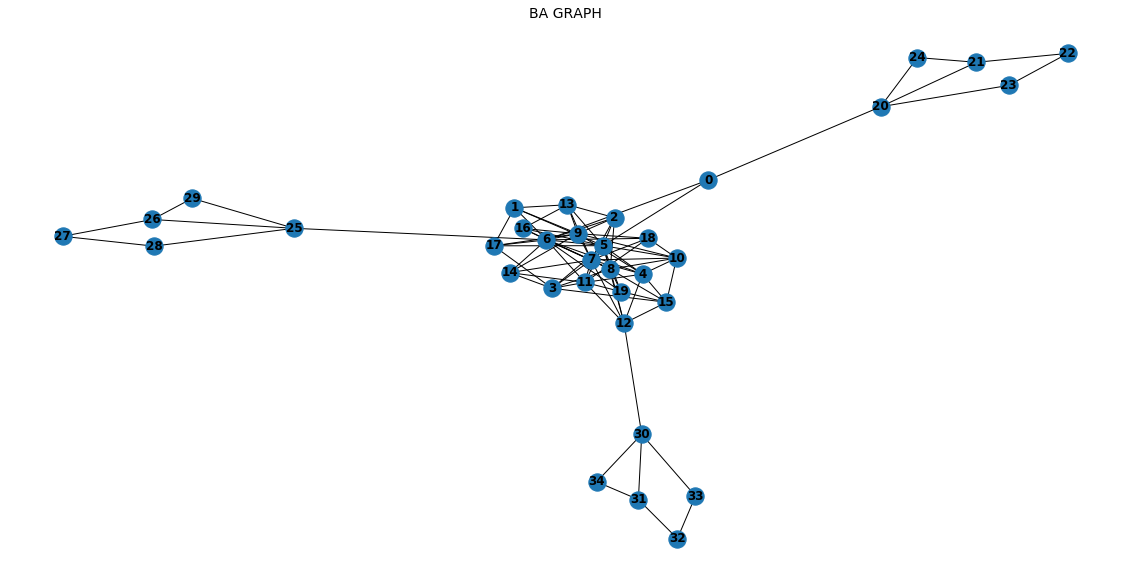

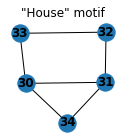

In [4]:
# Drawing of a house motif
start = 0
basis_type = "ba"
list_shapes = [["house"]] * 3
basis, role_id = eval(basis_type)(start, width=20, m=5)
print("Role Id of the BA graph :\n", role_id)

n_basis, n_shapes = nx.number_of_nodes(basis), len(list_shapes)
start += n_basis  # indicator of the id of the next node
print("Indicator of the id of the next node :", start)

# role_id are '0's for all the nodes of the basis, BA graph
print("Number of nodes in the BA graph : ", n_basis)
print("Number of motifs : ", n_shapes)

print("List of shapes :", list_shapes)
print("No. of shapes :", len(list_shapes))

spacing = math.floor(n_basis / n_shapes)
print("Spacing : ", spacing)
plugins = [int(k * spacing) for k in range(n_shapes)]
print("Plugins : ", plugins)
seen_shapes = {"basis": [0, n_basis]}
print("seen_shapes : ", seen_shapes)

for shape_index, shape in enumerate(list_shapes):
    shape_type = shape[0]
    print("\n-----------------------------------------")
    print("Shape_ID : " + str(shape_index) + " with shape type : " + str(shape_type))
    print(str(len(shape)) + " shapes with list of Shape :", shape)
    print("The shape starts from index 1 : ", shape[1:])
    
    args = [start]
    
    # More than one shape
    if len(shape) > 1:
        args += shape[1:]
        
    # Append 0 for the "role_start" in "house" function
    args += [0]
    print("\nThe list of arguments :", args)

    # *args parameter to send a non-keyworded variable-length argument list to function, 1-2 parameters in this case
    print("The first item in list of arguments :", args[0])
    print("The second item in list of arguments :", args[1])

    # Creating the "house" motif
    graph_s, roles_graph_s = eval(shape_type)(*args)
    n_s = nx.number_of_nodes(graph_s)
    
    try:
        # Get the last label from first index
        col_start = seen_shapes[shape_type][0]
    except:
        # Get the max label value 1
        col_start = np.max(role_id) + 1
        seen_shapes[shape_type] = [col_start, n_s]
    print("Column start :", col_start)
    print("Observe seen_shapes : ", seen_shapes)

    # Attach the shape to the basis
    basis.add_nodes_from(graph_s.nodes())
    basis.add_edges_from(graph_s.edges())
    # Connecting the motif to the BA graph from node 20 to 0, 25 to 6 and 30 to 12
    basis.add_edges_from([(start, plugins[shape_index])])
    
    # start = 0; col_start = 1; roles_graph_s = [0, 0, 1, 1, 2]
    temp_labels = [r + col_start for r in roles_graph_s]
    # temp_labels increment roles_graph_s by col_start

    # role_id is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    # Append labels of motif to the labels of BA graph
    role_id += temp_labels
    print("Labels of BA graph with attached motifs :\n", role_id)
    print("No. of nodes in attached graph : ", nx.number_of_nodes(basis))
    
    start += n_s
    print("With attached motif nodes, index starts from : ", start)

# Plotting the basis "BA" graph
plt.figure(figsize=(20, 10))
plt.title('BA graph'.upper(), y=1.0, fontsize=14)
nx.draw(basis, with_labels=True, font_weight='bold')

# Plot the motif "house" graph
plt.figure(figsize=(2, 2))
plt.title('"House" motif', y=1.0, fontsize=12)
nx.draw(graph_s, with_labels=True, font_weight='bold')
plt.show()

In [5]:
seen_shapes

{'basis': [0, 20], 'house': [1, 5]}

In [6]:
print("Information of the motif graph :\n", nx.info(graph_s))

Information of the motif graph :
 Name: 
Type: Graph
Number of nodes: 5
Number of edges: 6
Average degree:   2.4000


# Features generation

In [7]:
""" utils/featgen.py
Node feature generators.
"""

import abc

class FeatureGen(metaclass=abc.ABCMeta):
    """Feature Generator base class."""
    @abc.abstractmethod
    def gen_node_features(self, G):
        pass

class ConstFeatureGen(FeatureGen):
    """Constant Feature class."""
    def __init__(self, val):
        print("Values in Constant Feature Generator : ", val)
        self.val = val

    def gen_node_features(self, G):
        print("Generate constant feature for " + str(len(G.nodes())) + " nodes.")
        feat_dict = {i:{'feat': np.array(self.val, dtype=np.float32)} for i in G.nodes()}
        print ('feat_dict[0]["feat"]:', feat_dict[0]['feat'].dtype)
        nx.set_node_attributes(G, feat_dict)
        print ('G.nodes[0]["feat"]:', G.nodes[0]['feat'].dtype)

In [8]:
"""gengraph.py
   Generating and manipulaton the synthetic graphs needed for the paper's experiments.
"""

####################################
#
# Experiment utilities
#
####################################
def perturb(graph_list, p):
    """ Perturb the list of (sparse) graphs by adding/removing edges.
    Args:
        p: proportion of added edges based on current number of edges.
    Returns:
        A list of graphs that are perturbed from the original graphs.
    """
    perturbed_graph_list = []
    for G_original in graph_list:
        G = G_original.copy()
        edge_count = int(G.number_of_edges() * p)
        # randomly add the edges between a pair of nodes without an edge.
        for _ in range(edge_count):
            while True:
                u = np.random.randint(0, G.number_of_nodes())
                v = np.random.randint(0, G.number_of_nodes())
                if (not G.has_edge(u, v)) and (u != v):
                    break
            G.add_edge(u, v)
        perturbed_graph_list.append(G)
    return perturbed_graph_list

def preprocess_input_graph(G, labels, normalize_adj=False):
    """ Load an existing graph to be converted for the experiments.
    Args:
        G: Networkx graph to be loaded.
        labels: Associated node labels.
        normalize_adj: Should the method return a normalized adjacency matrix.
    Returns:
        A dictionary containing adjacency, node features and labels
    """
    adj = np.array(nx.to_numpy_matrix(G))
    if normalize_adj:
        sqrt_deg = np.diag(1.0 / np.sqrt(np.sum(adj, axis=0, dtype=float).squeeze()))
        adj = np.matmul(np.matmul(sqrt_deg, adj), sqrt_deg)

    existing_node = list(G.nodes)[-1]
    feat_dim = G.nodes[existing_node]["feat"].shape[0]
    f = np.zeros((G.number_of_nodes(), feat_dim), dtype=float)
    for i, u in enumerate(G.nodes()):
        f[i, :] = G.nodes[u]["feat"]

    # add batch dim
    adj = np.expand_dims(adj, axis=0)
    f = np.expand_dims(f, axis=0)
    labels = np.expand_dims(labels, axis=0)
    return {"adj": adj, "feat": f, "labels": labels}


####################################
#
# Generating synthetic graphs
#
####################################
def gen_syn1(nb_shapes=3, width_basis=20, feature_generator=None, m=5):
    """ Synthetic Graph #1:
    Start with Barabasi-Albert graph and attach house-shaped subgraphs.
    Args:
        nb_shapes         :  The number of shapes (here 'houses') that should be added to the base graph.
        width_basis       :  The width of the basis graph (here 'Barabasi-Albert' random graph).
        feature_generator :  A `FeatureGenerator` for node features. If `None`, add constant features to nodes.
        m                 :  number of edges to attach to existing node (for BA graph)
    Returns:
        G                 :  A networkx graph
        role_id           :  A list with length equal to number of nodes in the entire graph (basis
                          :  + shapes). role_id[i] is the ID of the role of node i. It is the label.
        name              :  A graph identifier
    """
    basis_type = "ba"
    list_shapes = [["house"]] * nb_shapes

    plt.figure(figsize=(8, 6), dpi=300)

    # synthetic_structsim
    G, role_id, _ = build_graph(width_basis, basis_type, list_shapes, start=0, m=5)
    G = perturb([G], 0.01)[0]

    if feature_generator is None:
        # feature generator
        feature_generator = ConstFeatureGen(1)
    
    # Generate node features
    feature_generator.gen_node_features(G)

    name = basis_type + "_" + str(width_basis) + "_" + str(nb_shapes)
    
    print("------ Generated the Synthetic BA graph with 'House' motifs ------")
    print("Name of generated graph :", name)
    return G, role_id, name

In [9]:
def train_node_classifier(G, labels):
    # train/test split only for nodes
    num_nodes = G.number_of_nodes()
    train_ratio = 0.8
    num_train = int(num_nodes * train_ratio)

    idx = [i for i in range(num_nodes)]

    np.random.shuffle(idx)
    train_idx = idx[:num_train]
    test_idx = idx[num_train:]

    # Obtain data with adjacency, node features and labels
    data = preprocess_input_graph(G, labels)
    return data

Values in Constant Feature Generator :  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Constant feature generator :  <__main__.ConstFeatureGen object at 0x7fb4894d7780>
------ Building the Synthetic BA graph with 'House' motifs ------
Role Id of the BA graph :
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Indicator of the id of the next node : 20
Number of nodes in the BA graph :  20
Number of motifs :  3
List of shapes : [['house'], ['house'], ['house']]
No. of shapes : 3
Spacing :  6
Plugins :  [0, 6, 12]
seen_shapes :  {'basis': [0, 20]}

-----------------------------------------
Shape_ID : 0 with shape type : house
1 shapes with list of Shape : ['house']
The shape starts from index 1 :  []

The list of arguments : [20, 0]
The first item in list of arguments : 20
The second item in list of arguments : 0
Column start : 1
Observe seen_shapes :  {'basis': [0, 20], 'house': [1, 5]}
Labels of BA graph with attached motifs :
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

<Figure size 2400x1800 with 0 Axes>

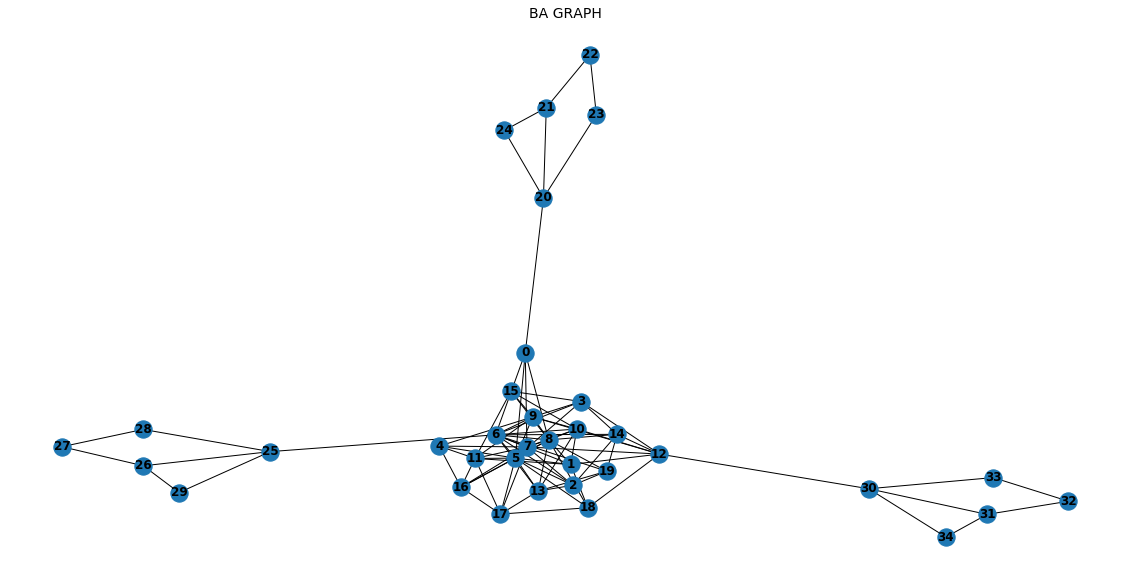

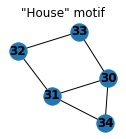

Generate constant feature for 35 nodes.
feat_dict[0]["feat"]: float32
G.nodes[0]["feat"]: float32
------ Generated the Synthetic BA graph with 'House' motifs ------
Name of generated graph : ba_20_3


In [10]:
# train.py : syn_task1 -> gen_syn1 -> train_node_classifier -> preprocess_input_graph
#G, labels, name = gen_syn1()
# args.input_dim
input_dim=10
# np.ones(input_dim, dtype=float) = [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]
constant_feature = ConstFeatureGen(np.ones(input_dim, dtype=float))
print("Constant feature generator : ", constant_feature)

G, labels, name = gen_syn1(feature_generator=constant_feature)

In [11]:
data = train_node_classifier(G, labels)
print("Train data :\n", data)

Train data :
 {'adj': array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 1., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]]), 'feat': array([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1.,

In [12]:
dict_shape = {key: value.shape for key, value in data.items()}
print("Shape for 'adj' in data : ", dict_shape['adj'])
print("Shape for 'feat' in data : ", dict_shape['feat'])
print("Shape for 'labels' in data : ", dict_shape['labels'])

Shape for 'adj' in data :  (1, 35, 35)
Shape for 'feat' in data :  (1, 35, 10)
Shape for 'labels' in data :  (1, 35)


In [13]:
# train.py
def syn_task1(args, writer=None):
    # data
    G, labels, name = gen_syn1(
        feature_generator=featgen.ConstFeatureGen(np.ones(args.input_dim, dtype=float))
    ) # gengraph

    num_classes = max(labels) + 1

    if args.method == "att":
        print("Method: att")
        model = models.GcnEncoderNode(
            args.input_dim,
            args.hidden_dim,
            args.output_dim,
            num_classes,
            args.num_gc_layers,
            bn=args.bn,
            args=args,
        )
    else:
        print("Method:", args.method)
        model = models.GcnEncoderNode(
            args.input_dim,
            args.hidden_dim,
            args.output_dim,
            num_classes,
            args.num_gc_layers,
            bn=args.bn,
            args=args,
        )
    if args.gpu:
        model = model.cuda()

    train_node_classifier(G, labels, model, args, writer=writer)

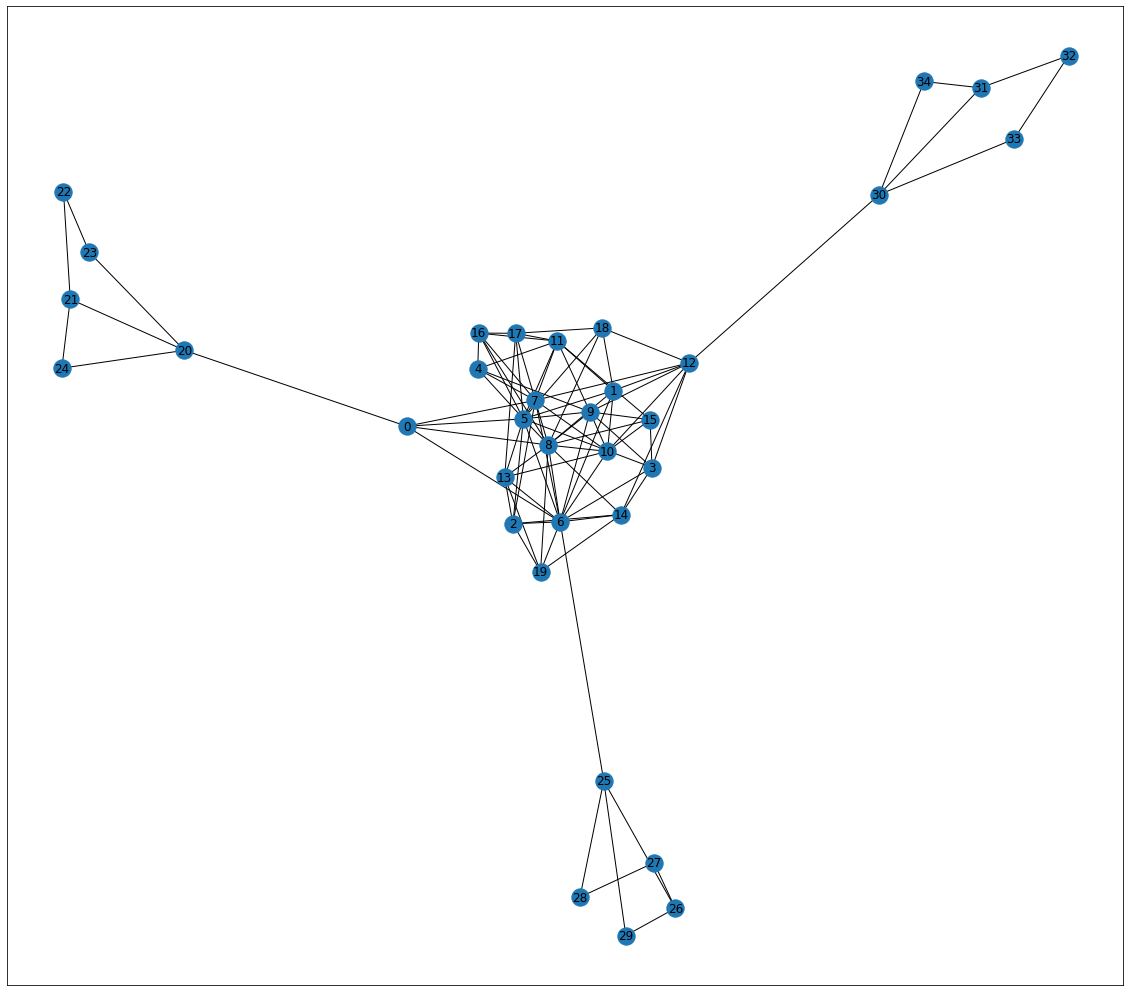

In [14]:
ba_pos = nx.spring_layout(G, k=0.3)

#plt.figure(figsize=(18, 16), dpi=300)
plt.figure(figsize=(20, 18))
nx.draw_networkx(G, ba_pos)

plt.show()

In [15]:
# Labels for 20 BA nodes + 15 house nodes
data["labels"]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        2, 2, 3, 1, 1, 2, 2, 3, 1, 1, 2, 2, 3]])

In [16]:
# Create csv file
def create_csv_file(filename, graph_data):
    data_path = os.path.join(PROJECT_ROOT_DIR, FOLDER)
    if not os.path.isdir(data_path):
        os.makedirs(data_path)
        
    headerStr = '# Example edge list network'
    # Create and overwrite existing file
    with open(FOLDER + '/'+ filename, 'w') as writeFile:
        filewriter = csv.writer(writeFile)
        filewriter.writerow([headerStr])
        filewriter.writerow(['Source', 'Target'])
        writeFile.close()
    # Append the edgelist information in append and binary mode
    with open(FOLDER + '/'+ filename, 'a+b') as writeFile:
        filewriter = csv.writer(writeFile)
        nx.write_edgelist(ba_graph, writeFile, comments='#', delimiter=',', data=False)
        writeFile.close()


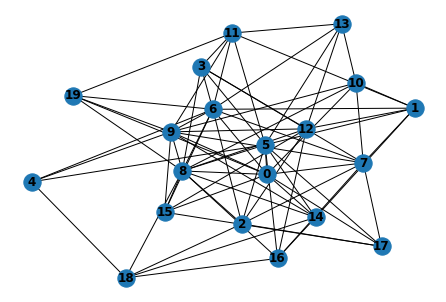

In [17]:
# BA model with nodes n and m links for new arriving node
ba_graph = nx.barabasi_albert_graph(n=20, m=5, seed=42) # seed will give unchanged ndoe degrees

nx.draw(ba_graph, with_labels=True, font_weight='bold')

# If need to draw in shell layout
#nx.draw_shell(ba_graph, nlist=[range(1, 10), range(5)], with_labels=True, font_weight='bold')

plt.show()

In [18]:
print(nx.info(ba_graph))

Name: 
Type: Graph
Number of nodes: 20
Number of edges: 75
Average degree:   7.5000


In [19]:
# Output to file to required for further node embeddings
create_csv_file(ba_edgelist_csv, ba_graph)

# Classic Zachary karate club network

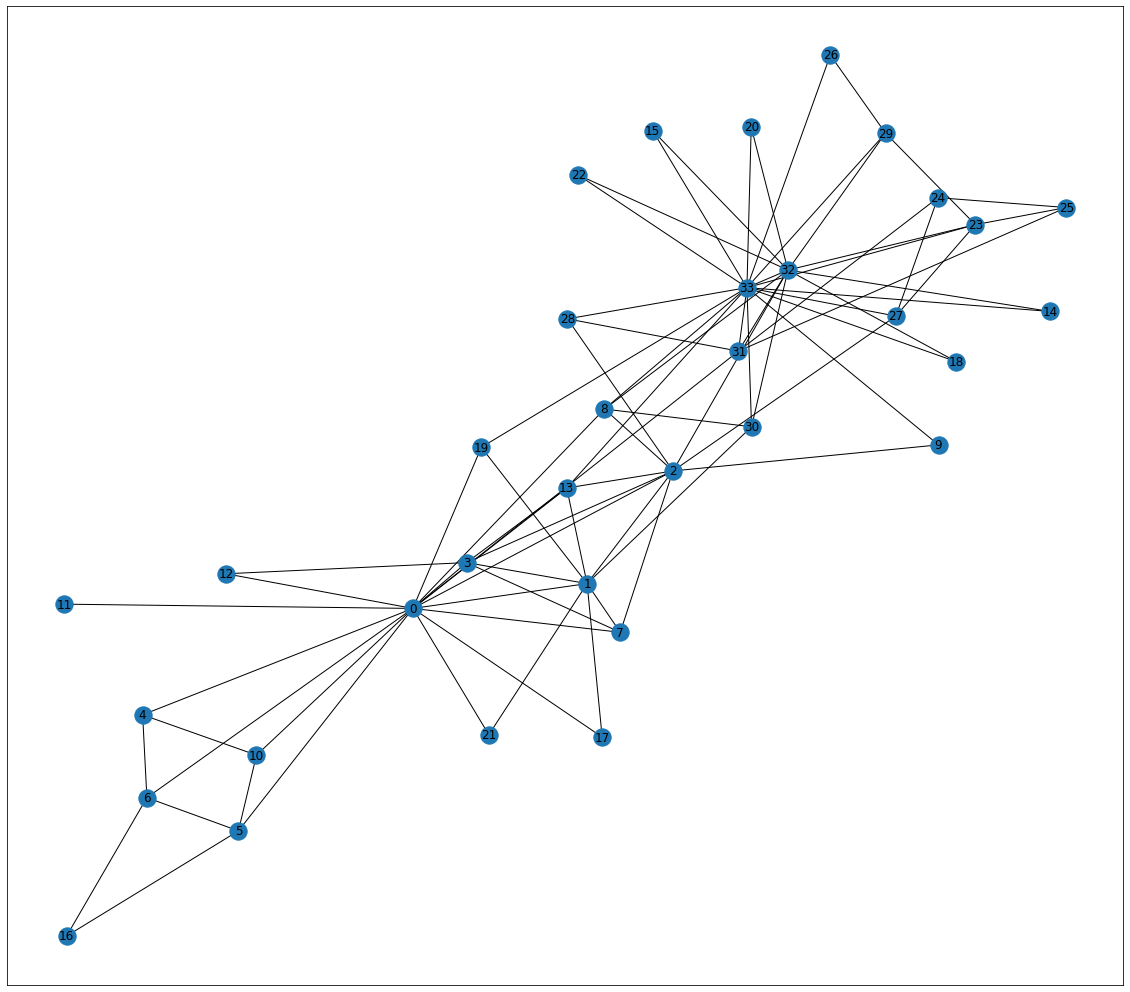

In [20]:
G = nx.karate_club_graph()
karate_pos = nx.spring_layout(G, k=0.3)

plt.figure(figsize=(20, 18))
nx.draw_networkx(G, karate_pos)

# End of Program